In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
dataset = pd.read_csv('/content/drive/My Drive/datos.csv' , index_col=0)
df=pd.DataFrame(dataset)
print(dataset.head(5))

                     ALAGON_NR  GRISEN_NR  ...  pred_48h  pred_72h
time                                       ...                    
2008-01-01 00:00:00     0.8100     0.4375  ...    0.7400      0.76
2008-01-01 01:00:00     0.8100     0.4725  ...    0.7325      0.76
2008-01-01 02:00:00     0.8100     0.5425  ...    0.7300      0.76
2008-01-01 03:00:00     0.8075     0.5500  ...    0.7200      0.76
2008-01-01 04:00:00     0.8000     0.5525  ...    0.7200      0.76

[5 rows x 10 columns]


In [13]:
#Depuración de los datos
dataset.index=pd.to_datetime(dataset.index)
mean_ALA=df["ALAGON_NR"].mean()
mean_GRI=df["GRISEN_NR"].mean()
mean_NOV=df["NOVILLAS_NR"].mean()
mean_TAU=df["TAUSTE_NR"].mean()
mean_TUD=df["TUDELA_NR"].mean()
dataset["ALAGON_NR"].fillna(2*dataset["NOVILLAS_NR"]/3, inplace=True)
dataset["ALAGON_NR"].fillna(mean_ALA, inplace=True)
dataset["GRISEN_NR"].fillna(mean_GRI, inplace=True)
dataset["NOVILLAS_NR"].fillna(3*dataset["ALAGON_NR"]/2, inplace=True)

dataset["NOVILLAS_NR"].fillna(mean_NOV, inplace=True)
dataset["TAUSTE_NR"].fillna(mean_TAU, inplace=True)
dataset["TUDELA_NR"].fillna(mean_TUD, inplace=True)
dataset.describe() 
   

,ALAGON_NR,GRISEN_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,pred_24h,pred_48h,pred_72h
count,95856.000000,95856.000000,95856.000000,95856.000000,95856.000000,95856.000000,95856.000000,95856.000000,95856.000000
mean,1.596885,0.415385,2.364005,0.613130,1.107738,1.261311,1.261382,1.261450,1.261511
std,1.303368,0.259794,1.366995,0.270589,0.530805,0.725114,0.725078,0.725042,0.725009
min,0.257500,0.070000,0.555000,0.225000,0.607500,0.470000,0.470000,0.470000,0.470000
25%,0.705000,0.150000,1.330000,0.490000,0.800000,0.795000,0.795000,0.795000,0.795000
50%,1.037500,0.415385,1.930000,0.580000,0.900000,0.950000,0.950000,0.950000,0.950000
75%,2.090000,0.620000,3.012500,0.682500,1.193125,1.515000,1.515000,1.515000,1.515000
max,7.895000,4.075000,8.377500,7.970000,5.847500,6.100000,6.100000,6.100000,6.100000


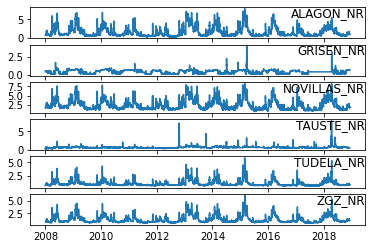

In [14]:
#Gráficas de las series temporales
from matplotlib import pyplot
values = dataset.values
groups = [ 0, 1, 2, 3, 4, 5]
i = 1
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(dataset.index,values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [15]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values (puede haber problemas con esto de cara a general el csv)
	if dropnan:
		agg.dropna(inplace=True)
	return agg
#n_in: Number of lag observations as input (X).
#n_out: Number of observations as output (y).
 

In [16]:
# normalizacion de los datos(
scaler = MinMaxScaler()
scaler.fit(values)
maxZGZ=scaler.data_max_[7]
minZGZ=scaler.data_min_[7]
values=scaler.transform(values)
values.shape

(95856, 10)

In [17]:
#Filtramos los valores riesgo=True
lag=8
supervised_riesgo=series_to_supervised(values[:,[0,1,2,3,4,5]],lag,1)
supervised_riesgo['pred_24h']=values[lag:,7]
supervised_riesgo['pred_48h']=values[lag:,8]
supervised_riesgo['pred_72h']=values[lag:,9]
supervised_riesgo['riesgo']=values[lag:,6]
riesgo_true=supervised_riesgo[supervised_riesgo['riesgo']==True]
riesgo_true.shape
riesgo_true.drop(['riesgo'],axis='columns',inplace=True)
riesgo_true.columns
riesgo_true.shape
supervised_riesgo.drop(['riesgo'],axis='columns',inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
#celda para usar solo los datos con riesgo True
n_train_hours= 8000
train=riesgo_true[:n_train_hours]
test=riesgo_true[n_train_hours:]
train=train.values
test=test.values
# dividir los conjuntos
train_X, train_y = train[:, 0:6*(lag+1)], train[:, 6*(lag+1):]
test_X, test_y = test[:, 0:6*(lag+1)], test[:,6*(lag+1):]
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], lag+1,6))
test_X = test_X.reshape((test_X.shape[0], lag+1,6))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8000, 9, 6) (8000, 3) (2074, 9, 6) (2074, 3)


In [19]:
#celda para usar todos los datos (sin filtrar) para hacer la predicción de todos los datos
n_train_hours = 60000

train = supervised_riesgo[:n_train_hours]
test = supervised_riesgo[n_train_hours:]
train=train.values
test=test.values
# dividir los conjuntos
train_X, train_y = train[:, 0:6*(lag+1)], train[:, 6*(lag+1):]
test_X, test_y = test[:, 0:6*(lag+1)], test[:,6*(lag+1):]
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], lag+1,6))
test_X = test_X.reshape((test_X.shape[0], lag+1,6))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(60000, 9, 6) (60000, 3) (35848, 9, 6) (35848, 3)


Epoch 1/3
112/112 - 3s - loss: 0.0788 - val_loss: 0.0222
Epoch 2/3
112/112 - 1s - loss: 0.0419 - val_loss: 0.0180
Epoch 3/3
112/112 - 1s - loss: 0.0305 - val_loss: 0.0167


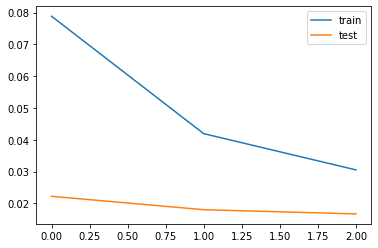

In [21]:
#CREACION DE LA RED NEURONAL
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
#from keras import optimizers
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model = Sequential()
model.add(LSTM(9, input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.3)) #se supone que para evitar overfitting
model.add(Dense(5))
model.add(Dropout(0.3))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=3, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [22]:

# make a prediction
y_hat=model.predict(test_X)
# calculate RMSE
#print('Test RMSE: %.5f' % testScore)
print(mean_squared_error(test_y[:,0],y_hat[:,0]))
print(mean_squared_error(test_y[:,1],y_hat[:,1]))
print(mean_squared_error(test_y[:,2],y_hat[:,2]))
#el val_loss nos da la media de los tres


0.013150915657307555
0.017036790330825766
0.019830530054788915


In [ ]:
#Cross validation (Esta celda NO VALE)
#train_X, test_X, train_y, test_y = train_test_split(riesgo_true.values[:,:6*(lag+1)],riesgo_true.values[:,['pred_24h','pred_48h','pred_72h']] , test_size=0.4, random_state=0)
#riesgo_true[:, 0:6*(lag+1)]
#cross_val_score(model.fit, riesgo_true.values[:,:6*(lag+1)],riesgo_true[['pred_24h','pred_48h','pred_72h']], cv=5)


n_train_hours= 7000
train=riesgo_true[n_train_hours:]
test=riesgo_true[:n_train_hours]
train=train.values
test=test.values
# split into input and outputs
train_X, train_y = train[:, 0:6*(lag+1)], train[:, 6*(lag+1):]
test_X, test_y = test[:, 0:6*(lag+1)], test[:,6*(lag+1):]#de momento solo predecimos a 24h
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], lag+1,6))#de momento solo un time step de 1
test_X = test_X.reshape((test_X.shape[0], lag+1,6))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model.fit(train_X, train_y, epochs=30, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
y_hat=model.predict(train_X)
print(mean_squared_error(train_y[:,0],y_hat[:,0]))
print(mean_squared_error(train_y[:,1],y_hat[:,1]))
print(mean_squared_error(train_y[:,2],y_hat[:,2]))
(mean_squared_error(train_y[:,0],y_hat[:,0])+mean_squared_error(train_y[:,1],y_hat[:,1])+mean_squared_error(train_y[:,2],y_hat[:,2]))/3

(5074, 51, 6) (5074, 3) (5000, 51, 6) (5000, 3)
Train on 5074 samples, validate on 5000 samples
Epoch 1/30
 - 8s - loss: 0.1941 - val_loss: 0.2570
Epoch 2/30
 - 8s - loss: 0.1962 - val_loss: 0.1777
Epoch 3/30
 - 8s - loss: 0.1555 - val_loss: 0.2021
Epoch 4/30
 - 8s - loss: 0.1630 - val_loss: 0.2126
Epoch 5/30
 - 8s - loss: 0.1559 - val_loss: 0.1575
Epoch 6/30
 - 8s - loss: 0.1400 - val_loss: 0.2044
Epoch 7/30
 - 8s - loss: 0.1369 - val_loss: 0.1620
Epoch 8/30
 - 8s - loss: 0.1374 - val_loss: 0.1625
Epoch 9/30
 - 8s - loss: 0.1318 - val_loss: 0.1864
Epoch 10/30
 - 8s - loss: 0.1269 - val_loss: 0.2688
Epoch 11/30
 - 8s - loss: 0.1339 - val_loss: 0.1702
Epoch 12/30
 - 8s - loss: 0.1155 - val_loss: 0.2625
Epoch 13/30
 - 8s - loss: 0.1289 - val_loss: 0.2270
Epoch 14/30
 - 8s - loss: 0.1250 - val_loss: 0.2203
Epoch 15/30
 - 8s - loss: 0.1289 - val_loss: 0.1856
Epoch 16/30
 - 8s - loss: 0.1242 - val_loss: 0.1936
Epoch 17/30
 - 8s - loss: 0.1201 - val_loss: 0.2219
Epoch 18/30
 - 8s - loss: 0.1

0.12432773402361648

In [ ]:
# Split-out validation dataset (la muestra aleatoria hace que se usan datos del test en el train) NO VALE
from sklearn import model_selection
array = riesgo_true.values
X = array[:,:6*(lag+1)]
Y = array[:,6*(lag+1):]
validation_size = 0.30
seed = 17
train_X, test_X, train_y, test_y = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], lag+1,6))
test_X = test_X.reshape((test_X.shape[0], lag+1,6))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model.fit(train_X, train_y, epochs=30, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


(7051, 51, 6) (7051, 3) (3023, 51, 6) (3023, 3)
Train on 7051 samples, validate on 3023 samples
Epoch 1/30
 - 10s - loss: 0.1172 - val_loss: 0.0751
Epoch 2/30
 - 10s - loss: 0.1164 - val_loss: 0.0768
Epoch 3/30
 - 10s - loss: 0.1132 - val_loss: 0.0761
Epoch 4/30
 - 10s - loss: 0.1147 - val_loss: 0.0727
Epoch 5/30
 - 10s - loss: 0.1101 - val_loss: 0.0729
Epoch 6/30
 - 10s - loss: 0.1127 - val_loss: 0.0742
Epoch 7/30
 - 10s - loss: 0.1098 - val_loss: 0.0718
Epoch 8/30
 - 10s - loss: 0.1114 - val_loss: 0.0714
Epoch 9/30
 - 10s - loss: 0.1068 - val_loss: 0.0695
Epoch 10/30
 - 10s - loss: 0.1039 - val_loss: 0.0692
Epoch 11/30
 - 10s - loss: 0.1056 - val_loss: 0.0691
Epoch 12/30
 - 10s - loss: 0.1037 - val_loss: 0.0684
Epoch 13/30
 - 10s - loss: 0.1042 - val_loss: 0.0702
Epoch 14/30
 - 10s - loss: 0.1024 - val_loss: 0.0659
Epoch 15/30
 - 10s - loss: 0.0998 - val_loss: 0.0668
Epoch 16/30
 - 10s - loss: 0.0995 - val_loss: 0.0689
Epoch 17/30
 - 10s - loss: 0.0974 - val_loss: 0.0678
Epoch 18/30


In [ ]:
#predicciones de la muestra aleatoria (NO VALE)
y_hat=model.predict(train_X)
print(mean_squared_error(train_y[:,0],y_hat[:,0]))
print(mean_squared_error(train_y[:,1],y_hat[:,1]))
print(mean_squared_error(train_y[:,2],y_hat[:,2]))

0.012787583368814187
0.04573435488119634
0.14543696142931556


(2000, 9, 6) (2000, 3) (2000, 9, 6) (2000, 3)
Epoch 1/100
63/63 - 1s - loss: 0.0211 - val_loss: 0.0066
Epoch 2/100
63/63 - 0s - loss: 0.0178 - val_loss: 0.0061
Epoch 3/100
63/63 - 0s - loss: 0.0162 - val_loss: 0.0061
Epoch 4/100
63/63 - 0s - loss: 0.0153 - val_loss: 0.0058
Epoch 5/100
63/63 - 0s - loss: 0.0143 - val_loss: 0.0056
Epoch 6/100
63/63 - 0s - loss: 0.0135 - val_loss: 0.0055
Epoch 7/100
63/63 - 0s - loss: 0.0130 - val_loss: 0.0053
Epoch 8/100
63/63 - 0s - loss: 0.0120 - val_loss: 0.0052
Epoch 9/100
63/63 - 0s - loss: 0.0112 - val_loss: 0.0051
Epoch 10/100
63/63 - 0s - loss: 0.0109 - val_loss: 0.0049
Epoch 11/100
63/63 - 0s - loss: 0.0103 - val_loss: 0.0048
Epoch 12/100
63/63 - 0s - loss: 0.0099 - val_loss: 0.0047
Epoch 13/100
63/63 - 0s - loss: 0.0099 - val_loss: 0.0046
Epoch 14/100
63/63 - 1s - loss: 0.0096 - val_loss: 0.0045
Epoch 15/100
63/63 - 0s - loss: 0.0091 - val_loss: 0.0045
Epoch 16/100
63/63 - 0s - loss: 0.0089 - val_loss: 0.0044
Epoch 17/100
63/63 - 0s - loss: 0.0

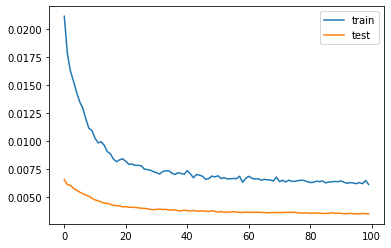

In [23]:
#Validacion manteniendo el orden de la serie (Day Forward-Chaining)
n_train_hours= 2000
n_test_hours=2000
train=riesgo_true[:n_train_hours]
test=riesgo_true[n_train_hours+2000:(n_train_hours+n_test_hours+2000)]
train=train.values
test=test.values
# split into input and outputs
train_X, train_y = train[:, 0:6*(lag+1)], train[:, 6*(lag+1):]
test_X, test_y = test[:, 0:6*(lag+1)], test[:,6*(lag+1):]#de momento solo predecimos a 24h
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], lag+1,6))
test_X = test_X.reshape((test_X.shape[0], lag+1,6))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history=model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



In [24]:
y_hat=model.predict(test_X)
y_hatinv=y_hat*(maxZGZ-minZGZ)+minZGZ
test_yinv=test_y*(maxZGZ-minZGZ)+minZGZ
EMC24=mean_squared_error(test_yinv[:,0],y_hatinv[:,0])
EMC48=mean_squared_error(test_yinv[:,1],y_hatinv[:,1])
EMC72=mean_squared_error(test_yinv[:,2],y_hatinv[:,2])
print(EMC24)
print(EMC48)
print(EMC72)
print(np.mean([EMC24,EMC48,EMC72]))                         

0.02125373413878264
0.08259810150606035
0.23163104963228134
0.1118276284257081


In [25]:
y_hat=model.predict(train_X)
y_hatinv=y_hat*(maxZGZ-minZGZ)+minZGZ
train_yinv=train_y*(maxZGZ-minZGZ)+minZGZ
EMC24=mean_squared_error(train_yinv[:,0],y_hatinv[:,0])
EMC48=mean_squared_error(train_yinv[:,1],y_hatinv[:,1])
EMC72=mean_squared_error(train_yinv[:,2],y_hatinv[:,2])
print(EMC24)
print(EMC48)
print(EMC72)
print(np.mean([EMC24,EMC48,EMC72]))  

0.03639943705171727
0.12709658200223362
0.30079401822000507
0.1547633457579853


In [ ]:
print(model.evaluate(test_X,test_y,  verbose=0))#para comprobar que funciona
#guardar modelo en JSON
import json
import h5py
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
#serializan los pesos (weights) para HDF5
model.save_weights("model.h5")
print("Modelo guardado en el PC")

0.10792649537324905
Modelo guardado en el PC


In [ ]:
#cargar el modelo guardado
from keras.models import model_from_json
# despues...(en el programa principal)
# carga el json y crea el modelo
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# se cargan los pesos (weights) en el nuevo modelo
loaded_model.load_weights("model.h5")
loaded_model.compile(loss='mean_squared_error', optimizer='adam')
print(loaded_model.evaluate(test_X,test_y,  verbose=0))#se ve que funciona adecuadamente



0.20497384407371283


'python-V'